<a href="https://colab.research.google.com/github/rchavarria3007/ml-ops-pavani/blob/main/FeatureEng.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ==============================================================================
# CÉLULA 1: Instalação de Bibliotecas
# ==============================================================================

# O '!' no início permite executar comandos do terminal diretamente no notebook.
# 'pip install' é o comando para instalar bibliotecas Python.
# 'category_encoders' é uma biblioteca que contém métodos de encoding avançados.
!pip install category_encoders

# Imprime uma mensagem de confirmação para o usuário saber que a instalação terminou.
print("Biblioteca 'category_encoders' instalada.")


# ==============================================================================
# CÉLULA 2: Setup e Carregamento de Dados
# ==============================================================================

# Importa a biblioteca pandas, essencial para manipulação de dados em tabelas (DataFrames). 'pd' é um apelido padrão.
import pandas as pd
# Importa a biblioteca numpy, usada para operações numéricas. 'np' é o apelido padrão.
import numpy as np
# Do scikit-learn, importa a classe PolynomialFeatures para criar features de interação e LabelEncoder para converter texto em números.
from sklearn.preprocessing import PolynomialFeatures, LabelEncoder
# Importa a biblioteca que acabamos de instalar, dando a ela o apelido 'ce'.
import category_encoders as ce
# Importa a função 'files' da biblioteca específica do Google Colab para permitir o upload de arquivos.
from google.colab import files
# Importa a biblioteca 'io' para manipular o arquivo carregado em memória.
import io

# Configura o pandas para sempre mostrar todas as colunas de um DataFrame, evitando que sejam ocultadas com '...'.
pd.set_option('display.max_columns', None)

# Imprime uma instrução para o usuário.
print("Por favor, faça o upload do arquivo 'WA_Fn-UseC_-HR-Employee-Attrition.csv'")
# Esta função do Colab abre uma janela de diálogo no navegador para que o usuário possa selecionar um arquivo.
# O arquivo carregado é armazenado na variável 'uploaded'.
uploaded = files.upload()

# 'try...except' é um bloco de tratamento de erros, para o código não quebrar se algo der errado.
try:
    # 'uploaded' é um dicionário. 'next(iter(uploaded))' pega o nome do primeiro (e único) arquivo que foi carregado.
    file_name = next(iter(uploaded))
    # 'uploaded[file_name]' contém os dados brutos (bytes) do arquivo.
    # 'io.BytesIO(...)' transforma esses bytes em um objeto que o pandas pode ler como se fosse um arquivo.
    # 'pd.read_csv(...)' lê esses dados e os carrega em um DataFrame chamado 'df'.
    df = pd.read_csv(io.BytesIO(uploaded[file_name]))

    # Imprime uma mensagem de sucesso, incluindo o nome do arquivo carregado.
    print(f"\nDataset '{file_name}' carregado com sucesso!")
    # Mostra as dimensões do DataFrame (linhas, colunas).
    print("Dimensões do dataset:", df.shape)
# 'except StopIteration:' trata o erro específico que ocorre se o usuário cancelar o upload.
except StopIteration:
    print("\nNenhum arquivo foi enviado.")
    # Se nenhum arquivo for carregado, 'df' é definido como 'None' para que as próximas células não tentem usá-lo.
    df = None
# 'except Exception as e:' captura qualquer outro erro que possa ocorrer durante o processo.
except Exception as e:
    print(f"Ocorreu um erro ao carregar o arquivo: {e}")
    df = None


# ==============================================================================
# CÉLULA 3: Criação de Features Base para Transformação
# ==============================================================================

# Verifica se o DataFrame 'df' foi carregado corretamente antes de prosseguir.
if df is not None:
    print("\n--- Criando Features Base ---")
    # Cria uma nova coluna 'OverTime_num' para representar 'OverTime' numericamente.
    # '.apply' executa uma função para cada valor da coluna. A função lambda retorna 1 se o valor for 'Yes', e 0 caso contrário.
    df['OverTime_num'] = df['OverTime'].apply(lambda x: 1 if x == 'Yes' else 0)

    # Cria a coluna 'IndiceDeBurnout' somando os fatores de risco (escalas invertidas de satisfação + hora extra).
    df['IndiceDeBurnout'] = (5 - df['WorkLifeBalance']) + (5 - df['JobSatisfaction']) + df['OverTime_num']

    # Cria a coluna 'IndiceDeSatisfacaoGeral' calculando a média das três métricas de satisfação.
    df['IndiceDeSatisfacaoGeral'] = (df['JobSatisfaction'] + df['EnvironmentSatisfaction'] + df['RelationshipSatisfaction']) / 3

    print("Features base 'IndiceDeBurnout' e 'IndiceDeSatisfacaoGeral' criadas.")
    # '.head()' exibe as 5 primeiras linhas das colunas especificadas para verificação.
    print(df[['IndiceDeBurnout', 'IndiceDeSatisfacaoGeral']].head())


# ==============================================================================
# CÉLULA 4: Técnica Avançada 1: Geração de Features Polinomiais
# ==============================================================================

# Novamente, verifica se o 'df' existe.
if df is not None:
    print("\n--- Gerando Features Polinomiais ---")
    # Cria uma lista com os nomes das colunas que serão usadas para gerar as features polinomiais.
    features_to_transform = ['MonthlyIncome', 'YearsAtCompany', 'IndiceDeBurnout', 'IndiceDeSatisfacaoGeral']
    # Cria um novo DataFrame 'poly_data' contendo apenas as colunas da lista acima.
    poly_data = df[features_to_transform]

    # Instancia (cria um objeto) do transformador PolynomialFeatures.
    # 'degree=2' significa que ele criará features até o segundo grau (x², y², x*y).
    # 'include_bias=False' evita a criação de uma coluna constante de valor 1.
    poly = PolynomialFeatures(degree=2, include_bias=False)

    # '.fit_transform()' aplica a transformação polinomial aos dados.
    poly_features = poly.fit_transform(poly_data)

    # '.get_feature_names_out()' gera os nomes das novas colunas criadas (ex: 'MonthlyIncome^2').
    # A list comprehension substitui espaços por '_X_' para nomes mais legíveis.
    poly_feature_names = [name.replace(' ', '_X_') for name in poly.get_feature_names_out(features_to_transform)]

    # Cria um novo DataFrame 'df_poly' com os dados transformados e os nomes corretos das colunas.
    df_poly = pd.DataFrame(poly_features, columns=poly_feature_names)

    print("Novas Features Polinomiais Geradas (amostra):")
    # Exibe as 5 primeiras linhas do novo DataFrame para ver o resultado.
    print(df_poly.head())


# ==============================================================================
# CÉLULA 5: Técnica Avançada 2: Geração de Features com Target Encoding
# ==============================================================================

if df is not None:
    print("\n--- Gerando Features com Target Encoding ---")
    # Instancia o LabelEncoder, que converte rótulos de texto em números.
    le = LabelEncoder()
    # Cria a coluna 'Attrition_encoded', convertendo 'No' para 0 e 'Yes' para 1.
    df['Attrition_encoded'] = le.fit_transform(df['Attrition'])

    # Cria uma lista com os nomes das colunas categóricas que queremos codificar.
    categorical_features_to_encode = ['JobRole', 'EducationField', 'MaritalStatus', 'Department']
    # Instancia o TargetEncoder, especificando as colunas que ele deve transformar.
    target_encoder = ce.TargetEncoder(cols=categorical_features_to_encode)

    # Aplica o Target Encoding. Ele usa as colunas categóricas e a coluna alvo ('Attrition_encoded') para calcular o valor de substituição.
    df_target_encoded = target_encoder.fit_transform(df[categorical_features_to_encode], df['Attrition_encoded'])

    # Renomeia as colunas do novo DataFrame para indicar que elas foram codificadas (ex: 'JobRole' vira 'JobRole_TargetEncoded').
    df_target_encoded = df_target_encoded.rename(columns={col: f'{col}_TargetEncoded' for col in df_target_encoded.columns})

    print("Novas Features com Target Encoding (amostra):")
    # Mostra as 5 primeiras linhas para verificar o resultado da codificação.
    print(df_target_encoded.head())


# ==============================================================================
# CÉLULA 6: Consolidação e Seleção das 10 Features Avançadas Finais
# ==============================================================================

if df is not None:
    print("\n--- Consolidando e Selecionando as 10 Features Finais ---")
    # 'pd.concat' junta os dois DataFrames de features ('df_poly' e 'df_target_encoded') lado a lado.
    # 'axis=1' especifica que a junção deve ser feita pelas colunas.
    df_advanced_features = pd.concat([df_poly, df_target_encoded], axis=1)

    # Cria uma lista final com os nomes das 10 features avançadas que escolhemos para o modelo.
    final_10_features_list = [
        # Features de Target Encoding
        'JobRole_TargetEncoded',
        'MaritalStatus_TargetEncoded',
        'EducationField_TargetEncoded',
        # Features de Potência (capturam efeitos não-lineares)
        'IndiceDeBurnout^2',
        'MonthlyIncome^2',
        # Features de Interação (capturam efeitos combinados)
        'MonthlyIncome_X_IndiceDeBurnout',
        'YearsAtCompany_X_IndiceDeBurnout',
        'MonthlyIncome_X_IndiceDeSatisfacaoGeral',
        'YearsAtCompany_X_IndiceDeSatisfacaoGeral',
        'IndiceDeBurnout_X_IndiceDeSatisfacaoGeral'
    ]

    # Cria o DataFrame final, contendo apenas as 10 colunas da lista acima.
    df_final_features = df_advanced_features[final_10_features_list]

    print("\nDataFrame Final com as 10 Features Avançadas Selecionadas:")
    # '.info()' imprime um resumo do DataFrame: nomes das colunas, contagem de valores não nulos e tipo de dados.
    df_final_features.info()

    print("\nAmostra das 10 Features Finais:")
    # Exibe as 5 primeiras linhas do DataFrame final.
    print(df_final_features.head())

Biblioteca 'category_encoders' instalada.
Por favor, faça o upload do arquivo 'WA_Fn-UseC_-HR-Employee-Attrition.csv'


Saving WA_Fn-UseC_-HR-Employee-Attrition.csv to WA_Fn-UseC_-HR-Employee-Attrition (1).csv

Dataset 'WA_Fn-UseC_-HR-Employee-Attrition (1).csv' carregado com sucesso!
Dimensões do dataset: (1470, 35)

--- Criando Features Base ---
Features base 'IndiceDeBurnout' e 'IndiceDeSatisfacaoGeral' criadas.
   IndiceDeBurnout  IndiceDeSatisfacaoGeral
0                6                 2.333333
1                5                 3.000000
2                5                 3.000000
3                5                 3.333333
4                5                 2.333333

--- Gerando Features Polinomiais ---
Novas Features Polinomiais Geradas (amostra):
   MonthlyIncome  YearsAtCompany  IndiceDeBurnout  IndiceDeSatisfacaoGeral  \
0         5993.0             6.0              6.0                 2.333333   
1         5130.0            10.0              5.0                 3.000000   
2         2090.0             0.0              5.0                 3.000000   
3         2909.0             8.0         

Justificativas e Impactos das 10 Features Avançadas
Grupo 1: Features de Target Encoding
Estas features convertem categorias de texto em um número que representa o risco de turnover associado àquela categoria.

1. JobRole_TargetEncoded (Cargo Codificado pelo Alvo)

Justificativa Técnica: A variável JobRole é categórica e possui muitas classes (alta cardinalidade). O Target Encoding a transforma em uma única variável numérica, onde o valor de cada cargo é diretamente proporcional à sua taxa de turnover. Isso cria um sinal forte e monotônico para o modelo.


Justificativa de Negócio e Impacto Esperado: A análise exploratória mostrou que cargos como "Representante de Vendas" e "Técnico de Laboratório" têm maior propensão ao turnover.

Impacto Esperado: O modelo aprenderá a atribuir um peso de risco maior a funcionários nesses cargos específicos, permitindo que o RH foque ações de retenção em funções mais vulneráveis.

2. MaritalStatus_TargetEncoded (Estado Civil Codificado pelo Alvo)

Justificativa Técnica: Converte a variável demográfica MaritalStatus em um valor numérico que reflete o risco. É mais eficiente que One-Hot Encoding e captura a ordem de risco (se houver) entre as categorias.


Justificativa de Negócio e Impacto Esperado: Foi observado que a proporção de solteiros no grupo de turnover é 50% maior. Isso sugere que podem ter menor vínculo com a empresa.

Impacto Esperado: O modelo poderá identificar perfis demográficos que, estatisticamente, possuem maior mobilidade no mercado de trabalho e menor barreira para mudar de emprego.

3. EducationField_TargetEncoded (Área de Formação Codificada pelo Alvo)

Justificativa Técnica: Similar às anteriores, resume o risco associado a cada campo de educação em um único número, simplificando a complexidade para o modelo.


Justificativa de Negócio e Impacto Esperado: As áreas de Marketing, Técnico de TI e RH apresentaram maior atrito.

Impacto Esperado: Esta feature permite que o modelo identifique se a formação do colaborador pertence a uma área com alta demanda no mercado ou com desafios internos específicos na empresa, ajustando o risco de saída.

Grupo 2: Features de Potência (Não-Linearidade)
Estas features ajudam o modelo a capturar relações onde o efeito de uma variável se acelera.

4. IndiceDeBurnout^2 (Índice de Burnout ao Quadrado)

Justificativa Técnica: A relação entre o burnout e a decisão de sair provavelmente não é linear. O termo quadrático permite ao modelo capturar um efeito acelerado, onde um aumento de 1 ponto no índice de burnout em níveis já altos tem um impacto muito maior do que em níveis baixos.

Justificativa de Negócio e Impacto Esperado: Um funcionário com burnout "nível 8" não tem apenas o dobro do risco de um com "nível 4"; o risco pode ser exponencialmente maior. Impacto Esperado: O modelo se tornará mais sensível para identificar funcionários que ultrapassaram um "ponto de inflexão" crítico, sinalizando uma necessidade de intervenção urgente.

5. MonthlyIncome^2 (Salário Mensal ao Quadrado)

Justificativa Técnica: Ajuda a modelar o efeito não-linear do salário. O impacto de um aumento de R1.000
e
ˊ
 muitomaiorparaquemganhaR2.000 do que para quem ganha R$15.000.


Justificativa de Negócio e Impacto Esperado: A análise mostrou que salários baixos são um forte motivador para a saída.

Impacto Esperado: O modelo poderá entender melhor a "utilidade marginal decrescente" do salário, ou seja, que a insatisfação com a remuneração é muito mais acentuada nas faixas salariais mais baixas.

Grupo 3: Features de Interação (Efeitos Combinados)
Estas são as features mais sofisticadas, pois medem como o efeito de uma variável muda na presença de outra.

6. MonthlyIncome_X_IndiceDeBurnout (Interação Salário vs. Burnout)

Justificativa Técnica: Cria uma variável que representa o efeito combinado do salário e do esgotamento.

Justificativa de Negócio e Impacto Esperado: Estar sobrecarregado é ruim. Estar sobrecarregado e se sentir mal pago é uma combinação explosiva. Impacto Esperado: O modelo poderá identificar com altíssima precisão o perfil de funcionário em maior risco: aquele que sente que seu esforço (burnout) não é recompensado financeiramente.

7. YearsAtCompany_X_IndiceDeBurnout (Interação Tempo de Casa vs. Burnout)

Justificativa Técnica: Testa se o impacto do burnout depende do tempo de casa do funcionário.

Justificativa de Negócio e Impacto Esperado: Um funcionário novo com alto burnout pode desistir rapidamente. Um funcionário antigo com alto burnout pode estar em seu limite final após anos de dedicação. Impacto Esperado: Ajuda o modelo a diferenciar o risco, permitindo ações distintas: para o novo, uma integração melhor; para o antigo, talvez uma reavaliação de carreira ou cargo.

8. MonthlyIncome_X_IndiceDeSatisfacaoGeral (Interação Salário vs. Satisfação)

Justificativa Técnica: Mede se o dinheiro pode "compensar" uma baixa satisfação geral com o ambiente e as relações.

Justificativa de Negócio e Impacto Esperado: Um funcionário com alta satisfação talvez tolere um salário menor. Um funcionário insatisfeito talvez não seja retido nem com um salário alto. Impacto Esperado: Permite ao modelo avaliar se as estratégias de retenção devem focar em remuneração ou em melhorias no ambiente, dependendo do perfil do funcionário.

9. YearsAtCompany_X_IndiceDeSatisfacaoGeral (Interação Tempo de Casa vs. Satisfação)

Justificativa Técnica: Avalia como a "paciência" com a insatisfação muda ao longo do tempo.


Justificativa de Negócio e Impacto Esperado: A fase de 3 a 5 anos é crítica. Estar insatisfeito após 5 anos pode ser um sinal de "promessas não cumpridas" e um preditor de saída mais forte do que a insatisfação no primeiro ano.

Impacto Esperado: O modelo poderá dar mais peso à insatisfação de funcionários mais antigos, que já deram tempo para a empresa "provar seu valor".

10. IndiceDeBurnout_X_IndiceDeSatisfacaoGeral (Interação Burnout vs. Satisfação Geral)

Justificativa Técnica: Testa a interação entre o esgotamento individual (ligado ao trabalho) e a satisfação com o ambiente (ligado ao contexto social e físico).

Justificativa de Negócio e Impacto Esperado: Um funcionário pode estar sobrecarregado, mas se ele gosta de seus colegas e do ambiente, isso pode funcionar como um fator de proteção.

Impacto Esperado: O modelo poderá identificar se um ambiente de trabalho positivo e boas relações interpessoais  são capazes de mitigar o risco de burnout, informando ao RH que investir em cultura pode ser um "antídoto" eficaz


In [ ]:
# ==============================================================================
# CÉLULA 7: Integração e Preparação do Dataset Final
# ==============================================================================
if df is not None:
    print("\n--- Integrando features e preparando o dataset final ---")

    # 1. Separar o alvo (y) antes de processar o restante das features
    y_final = df['Attrition_encoded'].copy()

    # 2. Selecionar colunas originais úteis e que não foram transformadas ainda
    # Removemos identificadores, a variável alvo original e as colunas que já usamos para criar as features avançadas.
    colunas_ja_usadas = [
        'JobRole', 'MaritalStatus', 'EducationField', 'Department', # Usadas no Target Encoding
        'MonthlyIncome', 'YearsAtCompany', 'WorkLifeBalance', 'JobSatisfaction', # Usadas nos índices e polinomiais
        'EnvironmentSatisfaction', 'RelationshipSatisfaction', 'OverTime',
        'Attrition', 'Attrition_encoded', 'OverTime_num', # Alvo e colunas temporárias
        'EmployeeCount', 'EmployeeNumber', 'StandardHours' # Colunas constantes ou de ID
    ]
    df_restante = df.drop(columns=colunas_ja_usadas)

    # 3. Aplicar One-Hot Encoding nas colunas categóricas restantes de baixa cardinalidade
    print("Aplicando One-Hot Encoding nas colunas categóricas restantes...")
    df_one_hot = pd.get_dummies(df_restante, drop_first=True) # drop_first=True para evitar multicolinearidade

    # 4. Juntar tudo para formar a matriz de features final (X)
    # df_one_hot: Features originais que não foram transformadas
    # df_final_features: Nossas 10 features avançadas
    X_final = pd.concat([df_one_hot, df_final_features], axis=1)

    print("\nDataset final para modelagem foi criado!")
    print("Dimensões da Matriz de Features (X_final):", X_final.shape)
    print("Dimensões do Vetor Alvo (y_final):", y_final.shape)


--- Integrando features e preparando o dataset final ---
Aplicando One-Hot Encoding nas colunas categóricas restantes...

Dataset final para modelagem foi criado!
Dimensões da Matriz de Features (X_final): (1470, 32)
Dimensões do Vetor Alvo (y_final): (1470,)



--- Analisando o impacto das features com RandomForest ---
Treinando modelo de base para extrair a importância das features...
Treinamento concluído.

Visualizando as 20 features mais importantes:


/tmp/ipython-input-4-1806117211.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20), palette='viridis')


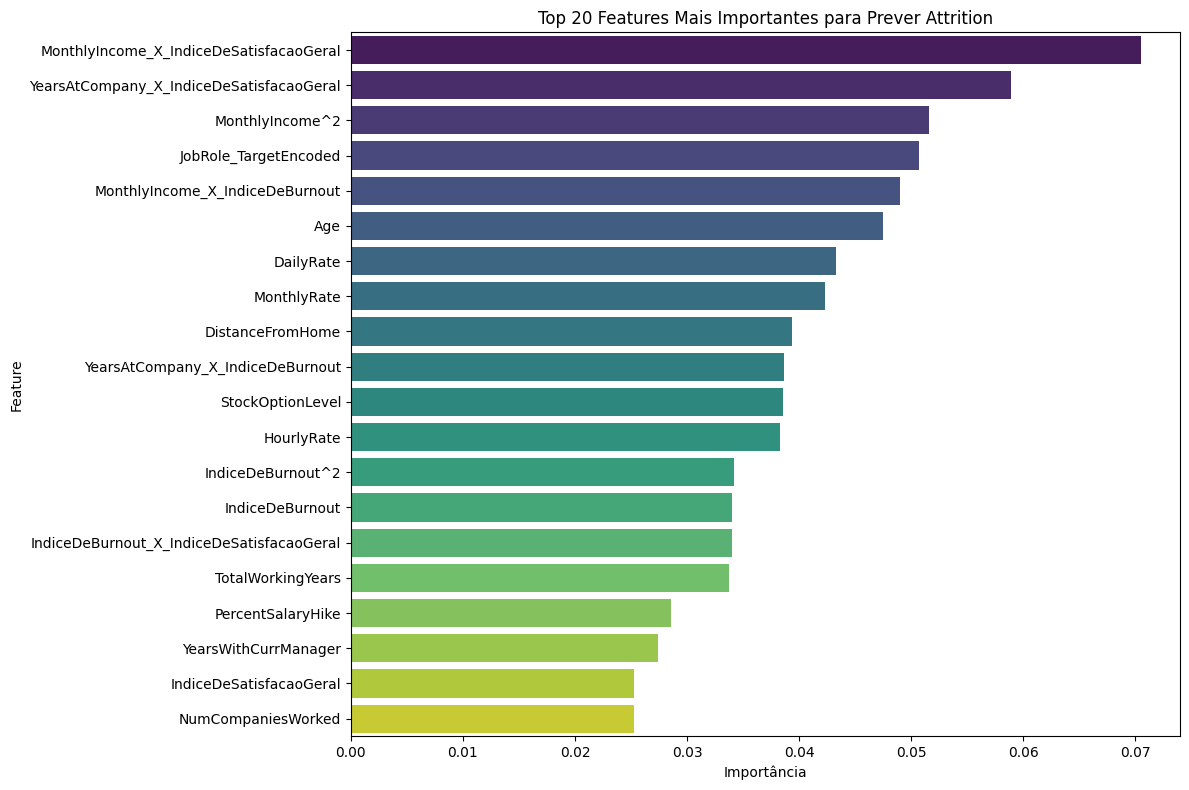


Análise: Verifique se as features que criamos (com '_TargetEncoded', '_X_' e '^2')
aparecem com destaque no topo do gráfico. Isso valida o impacto do seu trabalho!


In [ ]:
# ==============================================================================
# CÉLULA 8: Análise de Impacto das Novas Features
# ==============================================================================
if 'X_final' in locals():
    print("\n--- Analisando o impacto das features com RandomForest ---")

    # Importando as bibliotecas necessárias para o modelo e para a visualização
    from sklearn.ensemble import RandomForestClassifier
    import matplotlib.pyplot as plt
    import seaborn as sns

    # 1. Instanciar o modelo
    # Usamos class_weight='balanced' para compensar o desbalanceamento dos dados durante este teste.
    # Isso é crucial, conforme apontado na descrição do projeto.
    model_teste = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42, n_jobs=-1)

    # 2. Treinar o modelo
    print("Treinando modelo de base para extrair a importância das features...")
    model_teste.fit(X_final, y_final)
    print("Treinamento concluído.")

    # 3. Extrair e organizar a importância das features
    importances = model_teste.feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': X_final.columns,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    # 4. Visualizar as features mais importantes
    print("\nVisualizando as 20 features mais importantes:")

    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20), palette='viridis')
    plt.title('Top 20 Features Mais Importantes para Prever Attrition')
    plt.xlabel('Importância')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

    print("\nAnálise: Verifique se as features que criamos (com '_TargetEncoded', '_X_' e '^2')")
    print("aparecem com destaque no topo do gráfico. Isso valida o impacto do seu trabalho!")

In [ ]:
# ==============================================================================
# CÉLULA 9: Salvar os Artefatos para a Equipe
# ==============================================================================
if 'X_final' in locals():
    print("\n--- Salvando o dataset final processado ---")

    # Criar um DataFrame final para salvar, juntando X e y
    df_para_salvar = pd.concat([X_final, y_final], axis=1)

    # Salvar o DataFrame em um arquivo CSV
    df_para_salvar.to_csv('dataset_final_modelagem.csv', index=False)

    print("\nDataset final salvo com sucesso como 'dataset_final_modelagem.csv'.")
    print("Para fazer o download, clique no ícone de pasta à esquerda, encontre o arquivo,")
    print("clique nos três pontos ao lado dele e selecione 'Fazer o download'.")


--- Salvando o dataset final processado ---

Dataset final salvo com sucesso como 'dataset_final_modelagem.csv'.
Para fazer o download, clique no ícone de pasta à esquerda, encontre o arquivo,
clique nos três pontos ao lado dele e selecione 'Fazer o download'.
